# diff abundance analysis 

+ **目的**：计算菌在多个数据集的总效应。
+ **步骤**：先在每个数据集内用DEseq做丰度差异分析，得到每个OTU的logFC、pvalue、qvalue、lfcSE作为metafor的的输入，然后对每个OTU用metafor做meta-analysis（计算logFC在多个数据集的总效应值）
+ **参考文献**：Leveraging sequence-based faecal microbial community survey data to identify a composite biomarker for colorectal cancer. 您可以点击 [这里](https://pubmed.ncbi.nlm.nih.gov/28341746/) 获取原文
+ **参考教程**：
   + DESeq2：https://lashlock.github.io/compbio/R_presentation.html            https://workshop.veupathdb.org/bop/pdfs/beginner_DeSeq2.pdf  
   https://bioconductor.org/packages/release/bioc/manuals/DESeq2/man/DESeq2.pdf
   + metafor：http://wvbauer.com/lib/exe/fetch.php/talks:2016_viechtbauer_gesis_ma_with_metafor.pdf

In [1]:
library(ggplot2)

In [3]:
library('DESeq2') # for DA analysis 
library(tidyverse)
#library(MicrobeR)
library('metafor')  #for meta-analysis

In [4]:
H="#E69F00"
L="#0072B2"

# read otu table

In [5]:
#没有 normalize的raw data
data <- read.csv('gastritis-and-GC-abund-table.tsv',sep='\t',row.names=1)
head(data)

,ERR1995049,ERR1995038,ERR1994996,ERR1994997,ERR1995023,ERR1994992,ERR1995037,ERR1994989,ERR1994998,ERR1995010,⋯,SRR7534127,SRR7534043,SRR7534017,SRR7534015,SRR7534014,SRR7534028,SRR7534026,SRR7534116,SRR7534187,SRR7534189
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000477,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1001155,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1001762,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1001920,0,0,0,0,0,0,0,0,0,0,⋯,44,0,0,0,0,0,0,0,0,0
1003026,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
100361,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [6]:
dim(data)

[1] 2026  586

# read metadata

In [7]:
md <- read.csv('gastritis-and-GC-metadata.tsv',
            sep='\t',row.names=1)
head(md)

,Age,BMI,BioProject,CagA,Center_Name,Collection_Date,Condition,Country,Diagnosis,Gender,⋯,host_height,host_weight,hp,hp_relative_abundance,paried.sample,primer,sampleloc,sampling_method,smoker,case_control
,<dbl>,<lgl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<dbl>,<lgl>,<chr>,<chr>,<chr>,<lgl>,<chr>
ERR1995049,NA,NA,PRJEB21104,NA,CGR,,gastric cancer,United Kingdom,gastric cancer,,⋯,NA,NA,positive,78.20510,NA,27F _388R,,gastric mucosa biopsy,NA,case
ERR1995038,NA,NA,PRJEB21104,NA,CGR,,gastric cancer,United Kingdom,gastric cancer,,⋯,NA,NA,positive,11.57239,NA,27F _388R,,gastric mucosa biopsy,NA,case
ERR1994996,NA,NA,PRJEB21104,NA,CGR,,H.pylori gastritis,United Kingdom,gastritis,,⋯,NA,NA,positive,99.82093,NA,27F _388R,,gastric mucosa biopsy,NA,control
ERR1994997,NA,NA,PRJEB21104,NA,CGR,,H.pylori gastritis,United Kingdom,gastritis,,⋯,NA,NA,positive,99.90214,NA,27F _388R,,gastric mucosa biopsy,NA,control
ERR1995023,NA,NA,PRJEB21104,NA,CGR,,H.pylori atrophic gastritis,United Kingdom,gastritis,,⋯,NA,NA,positive,99.88107,NA,27F _388R,,gastric mucosa biopsy,NA,control
ERR1994992,NA,NA,PRJEB21104,NA,CGR,,H.pylori gastritis,United Kingdom,gastritis,,⋯,NA,NA,positive,92.87387,NA,27F _388R,,gastric mucosa biopsy,NA,control


In [8]:
# 后续分析要用上的分组信息不要有空格，有空格DEseq2无法构建DESeqDataSetFromMatrix
md[which(md$Diagnosis=='gastric cancer'),]$Diagnosis <- 'gastric_cancer'

In [9]:
table(md$BioProject)


 PRJEB21104  PRJEB26931 PRJNA313391 PRJNA375772 PRJNA481413 
         45         125          90         186         230 

In [10]:
#本notebook只分析以下3个数据集的数据
s_md <- subset(md,BioProject=='PRJEB26931' | BioProject=='PRJNA375772' | BioProject=='PRJNA481413')
dim(s_md)

[1] 541  51

In [11]:
s_md %>%group_by(Study, Diagnosis) %>% summarize(count=n())

`summarise()` has grouped output by 'Study'. You can override using the
`.groups` argument.


Study,Diagnosis,count
<chr>,<chr>,<int>
PRJEB26931,gastric_cancer,84
PRJEB26931,gastritis,41
PRJNA375772_Inner_Mongolia,gastric_cancer,36
PRJNA375772_Inner_Mongolia,gastritis,56
PRJNA375772_Xi_an,gastric_cancer,40
PRJNA375772_Xi_an,gastritis,54
PRJNA481413,gastric_cancer,115
PRJNA481413,gastritis,115


In [12]:
study <- unique(s_md$Study)
study

[1] "PRJEB26931"                 "PRJNA375772_Inner_Mongolia"
[3] "PRJNA375772_Xi_an"          "PRJNA481413"

In [13]:
md$Diagnosis <- factor(md$Diagnosis,levels=c('gastritis','gastric_cancer'))

# read taxonomy
用于后续注释差异的otu

In [14]:
# greengene 99% otu
taxo <- read.csv('/beegfs/db/greengenes/gg_13_8_otus/taxonomy/99_otu_taxonomy.txt',sep='\t',header=F)
names(taxo) <- c('ID','taxonomy')
head(taxo)

,ID,taxonomy
,<int>,<chr>
1,228054,k__Bacteria; p__Cyanobacteria; c__Synechococcophycideae; o__Synechococcales; f__Synechococcaceae; g__Synechococcus; s__
2,228057,k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rickettsiales; f__Pelagibacteraceae; g__; s__
3,73627,k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Mycobacteriaceae; g__Mycobacterium; s__
4,378462,k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Staphylococcaceae; g__Staphylococcus; s__
5,89370,k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillaceae; g__Anoxybacillus; s__kestanbolensis
6,370251,k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Oceanospirillales; f__Endozoicimonaceae; g__Endozoicomonas; s__montiporae


In [15]:
# function to get lowest taxomy

get_low_taxon <- function(a){
    b <-strsplit(a,';')
    c <- rev(as.vector(unlist(b)))
    for (i in c){
        l <- nchar(i)
        if (l>4){
            d <- i
            break           
        }
    }
return(d)
}

In [16]:
taxo$Taxonomy <- apply(taxo,1,get_low_taxon)
head(taxo)

,ID,taxonomy,Taxonomy
,<int>,<chr>,<chr>
1,228054,k__Bacteria; p__Cyanobacteria; c__Synechococcophycideae; o__Synechococcales; f__Synechococcaceae; g__Synechococcus; s__,g__Synechococcus
2,228057,k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rickettsiales; f__Pelagibacteraceae; g__; s__,f__Pelagibacteraceae
3,73627,k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Mycobacteriaceae; g__Mycobacterium; s__,g__Mycobacterium
4,378462,k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Staphylococcaceae; g__Staphylococcus; s__,g__Staphylococcus
5,89370,k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillaceae; g__Anoxybacillus; s__kestanbolensis,s__kestanbolensis
6,370251,k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Oceanospirillales; f__Endozoicimonaceae; g__Endozoicomonas; s__montiporae,s__montiporae


In [17]:
taxo$ID_Taxonomy <- paste(taxo$ID,'\n',taxo$Taxonomy)
taxo$Taxon <- paste0(taxo$ID,';',taxo$Taxonomy)
head(taxo)

,ID,taxonomy,Taxonomy,ID_Taxonomy,Taxon
,<int>,<chr>,<chr>,<chr>,<chr>
1,228054,k__Bacteria; p__Cyanobacteria; c__Synechococcophycideae; o__Synechococcales; f__Synechococcaceae; g__Synechococcus; s__,g__Synechococcus,228054 g__Synechococcus,228054; g__Synechococcus
2,228057,k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rickettsiales; f__Pelagibacteraceae; g__; s__,f__Pelagibacteraceae,228057 f__Pelagibacteraceae,228057; f__Pelagibacteraceae
3,73627,k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Mycobacteriaceae; g__Mycobacterium; s__,g__Mycobacterium,73627 g__Mycobacterium,73627; g__Mycobacterium
4,378462,k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Staphylococcaceae; g__Staphylococcus; s__,g__Staphylococcus,378462 g__Staphylococcus,378462; g__Staphylococcus
5,89370,k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillaceae; g__Anoxybacillus; s__kestanbolensis,s__kestanbolensis,89370 s__kestanbolensis,89370; s__kestanbolensis
6,370251,k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Oceanospirillales; f__Endozoicimonaceae; g__Endozoicomonas; s__montiporae,s__montiporae,370251 s__montiporae,370251; s__montiporae


# read oral otu 
用于后续标注哪些是口腔otu

In [18]:
oral_table <- read.csv('/beegfs/projects/20190707-HP-eradication/analyses/illumina-meta-analysis/all-data-meta-analysis/merge-99closed-ref-data-with-hp/rep-seqs2HOMD.tsv',sep='\t',check.names=F,row.names = 1)
head(oral_table,2)

,1000481,1000563,1000973,1001488,1001762,1001920,1002387,100284,1003026,1003175,⋯,996487,996933,997021,997210,997606,997803,997957,998028,998587,999477
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
002_3433,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
003_0566,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [19]:
oralotu <- names(oral_table)

# diff abundance analysis

In [20]:
table(md$Diagnosis)


     gastritis gastric_cancer 
           331            345 

In [21]:
options( warn = -1 )
per_study_res <- data.frame()

for (cohort in study){

    md_s <- subset(md,Study==cohort)                       #filter出一个数据集的数据
    sample_ids <- intersect(row.names(md_s),names(data))    #filter出一个数据集的数据
    md_s <- md_s[sample_ids,]                                #filter出一个数据集的数据
    data_s <- data[,sample_ids]                               #filter出一个数据集的数据
    data_s <-  data_s[which(rowSums(data_s) > 10),] +1        #filter出单个数据集内总丰度大于10的OTU,丰度加1 

    #以下详见DESeq tutorial
    group <- md_s['Diagnosis']
    format <- DESeqDataSetFromMatrix(data_s, group, design = ~Diagnosis) 
    analyze <- DESeq(format)
    diff_res <- results(analyze,contrast=c("Diagnosis","gastric_cancer","gastritis"))   #注意contrast的写法！！！对照组写后面。
    #diff_taxon <- subset(result, padj < 0.05 & abs(log2FoldChange) > 1)
    
    diff_res <- as.data.frame(diff_res) %>% 
    mutate('diff_otu'=row.names(diff_res),'Study'=cohort)
    message('######',cohort )
    per_study_res <- rbind(per_study_res,diff_res)
}    

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 145 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

######PRJEB26931

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' 

In [22]:
# Confidence interval
per_study_res <- per_study_res %>% mutate(CI_low= per_study_res$log2FoldChange-1.95*per_study_res$lfcSE,
                        CI_hig= per_study_res$log2FoldChange+1.95*per_study_res$lfcSE)  

In [23]:
head(per_study_res)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,diff_otu,Study,CI_low,CI_hig
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1000477,1.304679,-0.50370871,0.2434915,-2.0686910,3.857509e-02,6.570209e-02,1000477,PRJEB26931,-0.97851717,-0.02890026
1001155,1.445967,-0.07684687,0.2420116,-0.3175338,7.508386e-01,7.944745e-01,1001155,PRJEB26931,-0.54876948,0.39507575
1001920,2.230140,1.16814836,0.3197923,3.6528350,2.593609e-04,7.207502e-04,1001920,PRJEB26931,0.54455345,1.79174326
1003026,1.518172,0.41434496,0.2546137,1.6273472,1.036634e-01,1.516185e-01,1003026,PRJEB26931,-0.08215184,0.91084176
1004910,11.264242,-2.85046771,0.3260781,-8.7416706,2.296883e-18,2.004553e-17,1004910,PRJEB26931,-3.48632009,-2.21461533
1005820,1.476184,-0.42914880,0.2495400,-1.7197594,8.547619e-02,1.295020e-01,1005820,PRJEB26931,-0.91575186,0.05745426


In [47]:
per_study_res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,diff_otu,Study,CI_low,CI_hig
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1000477,1.304679,-0.50370871,0.2434915,-2.06869105,3.857509e-02,6.570209e-02,1000477,PRJEB26931,-0.97851717,-0.02890026
1001155,1.445967,-0.07684687,0.2420116,-0.31753382,7.508386e-01,7.944745e-01,1001155,PRJEB26931,-0.54876948,0.39507575
1001920,2.230140,1.16814836,0.3197923,3.65283502,2.593609e-04,7.207502e-04,1001920,PRJEB26931,0.54455345,1.79174326
1003026,1.518172,0.41434496,0.2546137,1.62734720,1.036634e-01,1.516185e-01,1003026,PRJEB26931,-0.08215184,0.91084176
1004910,11.264242,-2.85046771,0.3260781,-8.74167061,2.296883e-18,2.004553e-17,1004910,PRJEB26931,-3.48632009,-2.21461533
1005820,1.476184,-0.42914880,0.2495400,-1.71975936,8.547619e-02,1.295020e-01,1005820,PRJEB26931,-0.91575186,0.05745426
1005897,1.543422,0.75432442,0.2819101,2.67576273,7.455941e-03,1.525867e-02,1005897,PRJEB26931,0.20459981,1.30404902
1007399,578.169565,-1.07069845,0.3162670,-3.38542569,7.106795e-04,1.821547e-03,1007399,PRJEB26931,-1.68741912,-0.45397779
1007646,4.617511,-1.26345013,0.2517230,-5.01920797,5.188495e-07,1.838608e-06,1007646,PRJEB26931,-1.75431000,-0.77259026


In [24]:
# select otu appears in more than three data sets
r <- per_study_res %>% group_by(diff_otu) %>% summarize(count=n()) %>% subset(count>=3) #diff_otu
#r

In [48]:
r

diff_otu,count
<chr>,<int>
1000477,3
1001155,3
1001920,4
1003026,4
1004910,4
1005820,4
1005897,3
1007646,4
1010222,3


In [50]:
a=per_study_res %>% subset(diff_otu==1000477)

In [51]:
 rma(log2FoldChange,lfcSE, data = a)


Random-Effects Model (k = 3; tau^2 estimator: REML)

tau^2 (estimated amount of total heterogeneity): 0 (SE = 0.2567)
tau (square root of estimated tau^2 value):      0
I^2 (total heterogeneity / total variability):   0.00%
H^2 (total variability / sampling variability):  1.00

Test for Heterogeneity:
Q(df = 2) = 0.6081, p-val = 0.7378

Model Results:

estimate      se     zval    pval    ci.lb   ci.ub 
 -0.3066  0.2924  -1.0486  0.2944  -0.8797  0.2665    

---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [25]:
# calculate combined logFC for otus that appears in more than three data sets

Per_otu <- data.frame()
otu <- c()
for (i in r$diff_otu){
    per_otu <- per_study_res %>% subset(diff_otu==i)
    ma_model_1 <- rma(log2FoldChange,lfcSE, data = per_otu)  #见metafor包教程
    p <- ma_model_1$pval
    
    if (p < 0.01){ #筛选出p小于0.01的otu
        otu <- c(otu,i)
        per_otu_combind <- data.frame(baseMean='', log2FoldChange=ma_model_1$b[1], 
                      lfcSE='', stat='',pvalue='', 
                      padj=p, diff_otu=i,Study ='Combined', CI_low=ma_model_1$ci.lb,CI_hig=ma_model_1$ci.ub)
        per_otu_res <- rbind(per_otu,per_otu_combind)
        Per_otu <- rbind(Per_otu,per_otu_res)
    
    }
}

In [56]:
Per_otu

,diff_otu,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Study,CI_low,CI_hig,Significant,taxonomy,Taxonomy,ID_Taxonomy,Taxon,diff_oral,Taxon_oral,taxon_oral,absFC
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>
80,359079,28.3375220773765,3.686162,0.374836889718477,9.83404169670773,8.0328706855524e-23,6.426297e-20,PRJNA375772_Xi_an,2.955230,4.417094,GC enriched,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Streptococcaceae; g__Streptococcus; s__anginosus,s__anginosus,359079 s__anginosus,359079; s__anginosus,*,* 359079; s__anginosus,* 359079 s__anginosus,3.686162
108,4318284,22.0168739457133,3.417849,0.44613916387601,7.66094823640123,1.84565242381139e-14,3.281160e-12,PRJNA375772_Xi_an,2.547878,4.287820,GC enriched,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Veillonellaceae; g__Dialister; s__,g__Dialister,4318284 g__Dialister,4318284; g__Dialister,*,* 4318284; g__Dialister,* 4318284 g__Dialister,3.417849
92,4297119,21.4409215905562,3.372829,0.459005300474665,7.34812737075277,2.01002918226797e-13,1.406015e-10,PRJNA375772_Inner_Mongolia,2.477769,4.267890,GC enriched,k__Bacteria; p__Fusobacteria; c__Fusobacteriia; o__Fusobacteriales; f__Leptotrichiaceae; g__Leptotrichia; s__,g__Leptotrichia,4297119 g__Leptotrichia,4297119; g__Leptotrichia,*,* 4297119; g__Leptotrichia,* 4297119 g__Leptotrichia,3.372829
129,4396516,8.10370047956267,3.311667,0.286075798444304,11.5761886224211,5.44118488162603e-31,2.920103e-29,PRJNA481413,2.753820,3.869515,GC enriched,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__; s__,f__Lachnospiraceae,4396516 f__Lachnospiraceae,4396516; f__Lachnospiraceae,,4396516; f__Lachnospiraceae,4396516 f__Lachnospiraceae,3.311667
148,4458501,53.1244279198637,3.303541,0.437114182038526,7.55761645497269,4.10522431211231e-14,6.568359e-12,PRJNA375772_Xi_an,2.451169,4.155914,GC enriched,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__[Tissierellaceae]; g__Parvimonas; s__,g__Parvimonas,4458501 g__Parvimonas,4458501; g__Parvimonas,*,* 4458501; g__Parvimonas,* 4458501 g__Parvimonas,3.303541
169,509149,24.9200807158323,3.188118,0.439247183625994,7.25814210032748,3.92443165329178e-13,2.542454e-12,PRJEB26931,2.331586,4.044650,GC enriched,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Lactobacillaceae; g__Lactobacillus; s__,g__Lactobacillus,509149 g__Lactobacillus,509149; g__Lactobacillus,*,* 509149; g__Lactobacillus,* 509149 g__Lactobacillus,3.188118
136,4432270,8.38348162483357,3.096138,0.395341329752905,7.83155605089693,4.81868434270079e-15,3.462191e-14,PRJEB26931,2.325222,3.867053,GC enriched,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Lactobacillaceae; g__Lactobacillus; s__mucosae,s__mucosae,4432270 s__mucosae,4432270; s__mucosae,,4432270; s__mucosae,4432270 s__mucosae,3.096138
181,553611,16.1388849260706,3.049919,0.428997130022,7.10941568904187,1.16535263299832e-12,1.243043e-10,PRJNA375772_Xi_an,2.213375,3.886463,GC enriched,k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Bifidobacteriales; f__Bifidobacteriaceae; g__Bifidobacterium; s__,g__Bifidobacterium,553611 g__Bifidobacterium,553611; g__Bifidobacterium,*,* 553611; g__Bifidobacterium,* 553611 g__Bifidobacterium,3.049919
8,1018784,6.59699173898372,3.009824,0.372015626070391,8.0905840039936,5.93793305670248e-16,1.357242e-13,PRJNA375772_Xi_an,2.284393,3.735254,GC enriched,k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Prevotellaceae; g__Prevotella; s__,g__Prevotella,1018784 g__Prevotella,1018784; g__Prevotella,*,* 1018784; g__Prevotella,* 1018784 g__Prevotella,3.009824


In [57]:
Per_otu %>% subset(diff_otu==359079)

,diff_otu,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Study,CI_low,CI_hig,Significant,taxonomy,Taxonomy,ID_Taxonomy,Taxon,diff_oral,Taxon_oral,taxon_oral,absFC
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>
80,359079,28.3375220773765,3.6861616,0.374836889718477,9.83404169670773,8.0328706855524e-23,6.426297e-20,PRJNA375772_Xi_an,2.9552297,4.417094,GC enriched,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Streptococcaceae; g__Streptococcus; s__anginosus,s__anginosus,359079 s__anginosus,359079; s__anginosus,*,* 359079; s__anginosus,* 359079 s__anginosus,3.6861616
81,359079,3.92353117146893,2.2035705,0.258002347741671,8.54089324769514,1.33188216208306e-17,2.382589e-16,PRJNA481413,1.7004659,2.706675,GC enriched,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Streptococcaceae; g__Streptococcus; s__anginosus,s__anginosus,359079 s__anginosus,359079; s__anginosus,*,* 359079; s__anginosus,* 359079 s__anginosus,2.2035705
82,359079,,1.9856045,,,,1.501862e-03,Combined,0.7596068,3.211602,GC enriched,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Streptococcaceae; g__Streptococcus; s__anginosus,s__anginosus,359079 s__anginosus,359079; s__anginosus,*,* 359079; s__anginosus,* 359079 s__anginosus,1.9856045
79,359079,35.0079818106182,1.0219916,0.421449905794938,2.42494200901955,0.0153108322653839,9.076209e-02,PRJNA375772_Inner_Mongolia,0.2001643,1.843819,ns,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Streptococcaceae; g__Streptococcus; s__anginosus,s__anginosus,359079 s__anginosus,359079; s__anginosus,*,* 359079; s__anginosus,* 359079 s__anginosus,1.0219916
78,359079,10.2758699107571,0.9899914,0.368291778685599,2.68806280236122,0.00718678785501496,1.476507e-02,PRJEB26931,0.2718225,1.708160,ns,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Streptococcaceae; g__Streptococcus; s__anginosus,s__anginosus,359079 s__anginosus,359079; s__anginosus,*,* 359079; s__anginosus,* 359079 s__anginosus,0.9899914


In [26]:
length(otu)

[1] 44

In [27]:

Per_otu <- Per_otu %>% mutate(Significant=case_when(
padj<=0.01 & log2FoldChange>0 ~ "GC enriched",
padj<=0.01 & log2FoldChange<0 ~ "Gastritis enriched",
TRUE~"ns"
)) 

Per_otu$Significant <- factor(Per_otu$Significant,levels=c("GC enriched","Gastritis enriched","ns"))
Per_otu <- merge(Per_otu,taxo,by.x='diff_otu',by.y='ID')
#Per_otu <- merge(Per_otu,otu,by.x='diff_otu',by.y='otu')

In [28]:
head(Per_otu,2)

,diff_otu,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Study,CI_low,CI_hig,Significant,taxonomy,Taxonomy,ID_Taxonomy,Taxon
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>
1,1007646,4.61751119012647,-1.2634501,0.251723008821232,-5.01920797031515,5.18849549129029e-07,1.838608e-06,PRJEB26931,-1.754310,-0.7725903,Gastritis enriched,k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Moraxellaceae; g__Acinetobacter; s__,g__Acinetobacter,1007646 g__Acinetobacter,1007646; g__Acinetobacter
2,1007646,67.9677935166759,-0.3809722,0.339834379297875,-1.12105264928926,0.262265452319627,4.777466e-01,PRJNA375772_Inner_Mongolia,-1.043649,0.2817048,ns,k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Moraxellaceae; g__Acinetobacter; s__,g__Acinetobacter,1007646 g__Acinetobacter,1007646; g__Acinetobacter


## plot for diff OTUs

以下代码为整理数据画图，请忽略。

In [29]:
Per_otu$diff_oral <- ''
Per_otu[Per_otu$diff_otu %in% oralotu,]$diff_oral <- '*' 

Per_otu$Taxon_oral <- paste(Per_otu$diff_oral,Per_otu$Taxon) #use for 
Per_otu$taxon_oral <- paste(Per_otu$diff_oral,Per_otu$ID_Taxonomy) # use for single plot

Per_otu$absFC <- abs(Per_otu$log2FoldChange)  #use for filter top FC otu

In [30]:
# order by logFC for plot
Per_otu <- Per_otu[order(Per_otu$absFC, decreasing=T),] 
Per_otu$taxon_oral <- factor(Per_otu$taxon_oral,levels=subset(Per_otu,Study=='Combined')$taxon_oral) 

In [31]:
#write.csv(Per_otu,'diff-otu-DESeq2.csv')

In [32]:

s_taxon <- read.csv('/beegfs/projects/20190707-HP-eradication/analyses/illumina-meta-analysis/all-data-meta-analysis/merge-99closed-ref-data-with-hp/gastritis-and-GC-sample/line_taxonomy.csv',row.names = 1)
head(s_taxon,2)

,X_feature_id,taxonomy,kingdom,phylum,class,order,family,genus,species
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1000113,1000113,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__; g__; s__,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__,g__,s__
1000148,1000148,k__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Comamonadaceae; g__; s__,k__Bacteria,p__Proteobacteria,c__Betaproteobacteria,o__Burkholderiales,f__Comamonadaceae,g__,s__


In [33]:
Per_otu_new <- merge(Per_otu,s_taxon,by.x='diff_otu',by.y='X_feature_id')
dim(Per_otu_new)

[1] 211  27

In [34]:
Per_otu_new$line_taxon <- paste(Per_otu_new$diff_oral,Per_otu_new$diff_otu,'\n',Per_otu_new$order,'\n',Per_otu_new$family,'\n',Per_otu_new$genus,'\n',Per_otu_new$species)

In [35]:
head(Per_otu_new,2)

,diff_otu,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Study,CI_low,CI_hig,⋯,absFC,taxonomy.y,kingdom,phylum,class,order,family,genus,species,line_taxon
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1007646,4.61751119012647,-1.2634501,0.251723008821232,-5.01920797031515,5.18849549129029e-07,1.838608e-06,PRJEB26931,-1.754310,-0.7725903,⋯,1.2634501,k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Moraxellaceae; g__Acinetobacter; s__,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Moraxellaceae,g__Acinetobacter,s__,* 1007646 o__Pseudomonadales f__Moraxellaceae g__Acinetobacter s__
2,1007646,67.9677935166759,-0.3809722,0.339834379297875,-1.12105264928926,0.262265452319627,4.777466e-01,PRJNA375772_Inner_Mongolia,-1.043649,0.2817048,⋯,0.3809722,k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Moraxellaceae; g__Acinetobacter; s__,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Moraxellaceae,g__Acinetobacter,s__,* 1007646 o__Pseudomonadales f__Moraxellaceae g__Acinetobacter s__


In [36]:
# order for plot
Per_otu_new <- Per_otu_new[order(Per_otu_new$absFC, decreasing=T),] 
Per_otu_new$line_taxon <- factor(Per_otu_new$line_taxon,levels=subset(Per_otu_new,Study=='Combined')$line_taxon) 

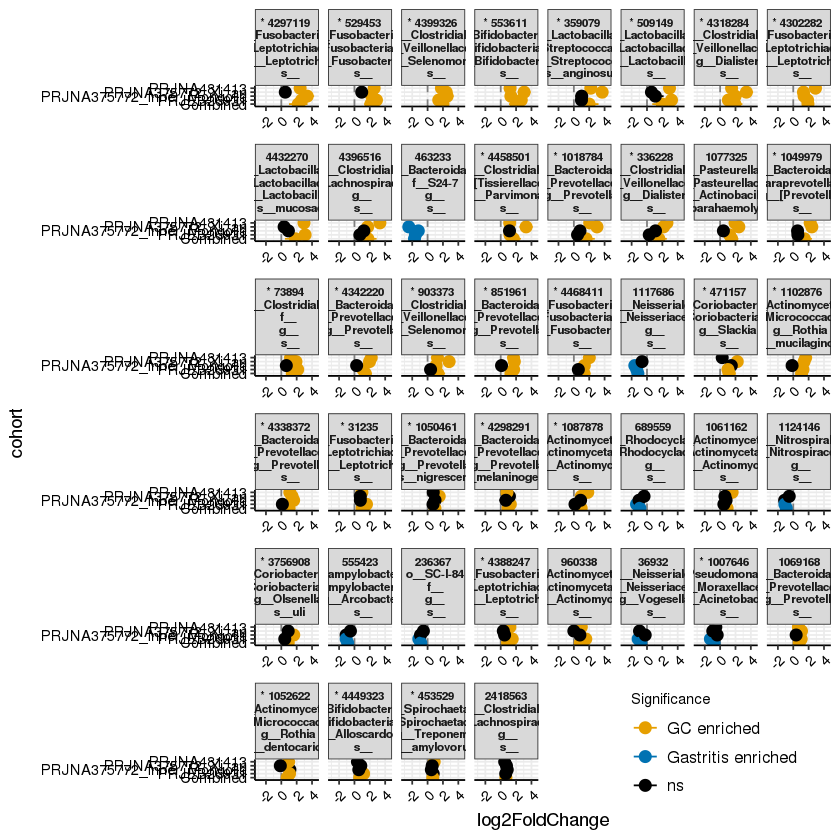

In [46]:
ggplot(Per_otu_new,aes(x=log2FoldChange, y=Study, color=Significant)) +  
geom_vline(xintercept = 0, linetype="dashed", color="grey50") +
geom_errorbarh(aes(xmin=CI_low, xmax=CI_hig), height=0 ) +
geom_point(size=3) +
facet_wrap(~line_taxon,ncol=8,scales="free_x") +
theme_bw()+
scale_color_manual(values=c(H,L,'black'))  +
theme(panel.border = element_blank(), axis.line = element_line()) +
theme(axis.text.x=element_text(angle=45, hjust=1,size=9),
      axis.text = element_text(size = 9,colour = 'black'),
      legend.title = element_text(size = 9),
      legend.text = element_text(size = 10),
      strip.text = element_text(size = 7,face = "bold"))+
theme(legend.position = c(.8,0.05))+
xlim(min(Per_otu$CI_low)+0.1,max(Per_otu$CI_hig)+0.1)+labs(y='cohort',color='Significance')
             
ggsave("combined_diff_otu_forest_plot.pdf", device="pdf", height=11, width=11, useDingbats=F)

## plot for top 20 OTUs

In [39]:
# select top diff OTUs
con <- subset(Per_otu,Study=='Combined')
con <- con[order(con$absFC, decreasing=T),] 
top<-con$diff_otu[1:20]
top_data <- Per_otu[Per_otu$diff_otu %in% top,]

# order for plot
top_data <- top_data[order(top_data$log2FoldChange, decreasing=F),]

# y axis
top_data$Taxon <- factor(top_data$Taxon,levels=subset(top_data,Study=='Combined')$Taxon) 
top_data$Taxon_oral <- factor(top_data$Taxon_oral,levels=subset(top_data,Study=='Combined')$Taxon_oral) 

In [40]:
#write_csv(subset(top_data,Study=='Combined'),'top_sig_diff_otu.csv')

In [41]:

#aligned taxonomy for plotting
taxonomy <- read.csv('/beegfs/projects/20190707-HP-eradication/analyses/illumina-meta-analysis/all-data-meta-analysis/merge-99closed-ref-data-with-hp/gastritis-and-GC-sample/aligned-taxonomy.csv',row.names = 1)
head(taxonomy,2)

,X_feature_id,align_taxa
,<int>,<chr>
1018784,1018784,1018784 o__Bacteroidales f__Prevotellaceae g__Prevotella s__
1049979,1049979,1049979 o__Bacteroidales f__[Paraprevotellaceae] g__[Prevotella] s__


In [42]:
new_top_data <- merge(top_data,taxonomy,by.x='diff_otu',by.y='X_feature_id')

In [43]:
# order for plotting
new_top_data <- new_top_data[order(new_top_data$log2FoldChange, decreasing=F),]
new_top_data$align_taxa <- factor(new_top_data$align_taxa,levels=subset(new_top_data,Study=='Combined')$align_taxa) 

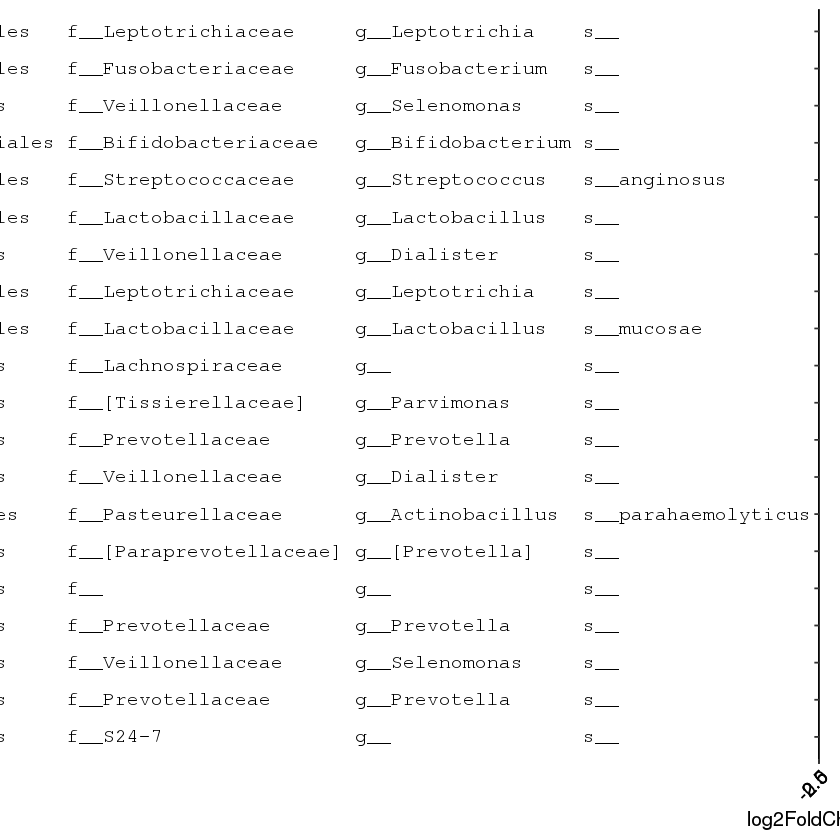

In [45]:
ggplot(new_top_data,aes(x=log2FoldChange, y=align_taxa, color=Significant)) +  
geom_vline(xintercept = 0, linetype="dashed", color="grey50") + 
geom_errorbarh(aes(xmin=CI_low, xmax=CI_hig),data=subset(new_top_data,Study=='Combined'), height=0 ) +
geom_point(aes(shape =Study),size=3)+
theme_bw() +
scale_color_manual(values=c(L,H,'grey'))  +
theme(panel.border = element_blank(), axis.line = element_line()) +
theme(axis.text.x=element_text(angle=45, hjust=1,size=12,colour = 'black'),
      axis.text.y = element_text(size = 12,colour = 'black',family = "mono"),
      axis.title=element_text(colour='black', size=12),
      legend.title = element_text(size = 10),
      legend.text = element_text(size = 11),
      )+ 
scale_shape_manual(values=c(17,1,3,4,5,7))+
xlim(min(Per_otu$CI_low)+0.3,max(Per_otu$CI_hig)+0.1) +labs(shape='Cohort',color='Significance',y='Taxon')

ggsave("top20-diff_combined_sign_diff_otu_aliged_forest_plot.pdf",
      device="pdf", height=6, width=15, useDingbats=F)